In [1]:
import sys

sys.path.append(".")

import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models.unet import UNet
from src.models.vae import *
from src.modules.latent_rectified_flow import LatentRectifiedFlowModule
from src.modules.autoencoder import AutoEncoder

import pytorch_lightning as pl

import sys

sys.path.append(".")

/home/engineer/anaconda/envs/palamariuk-genai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}\n')

Device: cuda



# 4

(10pt.) Implement and train diffusion model (pixel and latent based) using Rectified Flow

In [4]:
vae = VariationalAutoEncoder(in_channels=1).to(device)
autoencoder = AutoEncoder(vae, lr=1e-3).to(device)
autoencoder.vae = torch.load('models/weights/vae_100.pth', weights_only=False).to(device)

/home/engineer/anaconda/envs/palamariuk-genai/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'vae' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vae'])`.


In [5]:
model_flow = UNet(
    in_channels=1,
    out_channels=1,
    base_channels=64,
    channel_mults=(1, 2, 4),
    num_res_blocks=2,
    time_emb_dim=256
).to(device)

flow_module = LatentRectifiedFlowModule(model=model_flow, autoencoder=autoencoder, latent_dim=64, lr=1e-3, mode="flow").to(device)

In [21]:
retrain = True

if retrain:
    trainer = pl.Trainer(max_epochs=40, accelerator="gpu" if torch.cuda.is_available() else "cpu")
    trainer.fit(flow_module, train_loader)
    torch.save(flow_module.model, 'models/weights/latent_flow_model.pth')
else:
    flow_module.model = torch.load('models/weights/latent_flow_model.pth', weights_only=False).to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | model       | UNet        | 13.9 M | eval 
1 | autoencoder | AutoEncoder | 223 K  | train
2 | criterion   | MSELoss     | 0      | train
----------------------------------------------------
14.1 M    Trainable params
0         Non-trainable params
14.1 M    Total params
56.527    Total estimated model params size (MB)
25        Modules in train mode
168       Modules in eval mode


Epoch 39: 100%|██████████| 235/235 [00:12<00:00, 18.46it/s, v_num=28]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 235/235 [00:13<00:00, 17.06it/s, v_num=28]


In [23]:
flow_module = flow_module.to(device)

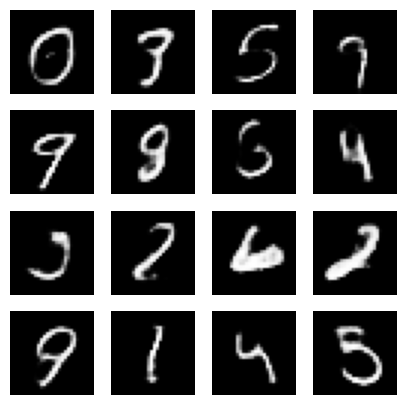

In [35]:
noise_samples = torch.randn(16, 1, 8, 8, device=device)
samples = flow_module.sample(noise_samples, num_steps=100, image=True).cpu()

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.show()

In [27]:
fixed_dataset = flow_module.generate_fixed_pairs(num_fixed=10000, batch_size=256, num_steps=200)
fixed_loader = DataLoader(fixed_dataset, batch_size=256, shuffle=True)
torch.save(fixed_dataset, "fixed_pairs_dataset.pt")

In [28]:
model_reflow = UNet(
    in_channels=1,
    out_channels=1,
    base_channels=64,
    channel_mults=(1, 2, 4),
    num_res_blocks=2,
    time_emb_dim=256
).to(device)

reflow_module = LatentRectifiedFlowModule(model=model_reflow, autoencoder=autoencoder, latent_dim=64, lr=1e-3, mode="reflow").to(device)

In [29]:
retrain = True

if retrain:
    trainer = pl.Trainer(max_epochs=10, accelerator="gpu" if torch.cuda.is_available() else "cpu")
    trainer.fit(reflow_module, fixed_loader)
    torch.save(reflow_module.model, 'models/weights/reflow_model.pth')
else:
    reflow_module.model = torch.load('models/weights/reflow_model.pth', weights_only=False).to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | model       | UNet        | 13.9 M | train
1 | autoencoder | AutoEncoder | 223 K  | train
2 | criterion   | MSELoss     | 0      | train
----------------------------------------------------
14.1 M    Trainable params
0         Non-trainable params
14.1 M    Total params
56.527    Total estimated model params size (MB)
193       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 39/39 [00:01<00:00, 27.94it/s, v_num=29]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 39/39 [00:02<00:00, 15.46it/s, v_num=29]


In [30]:
reflow_module = reflow_module.to(device)

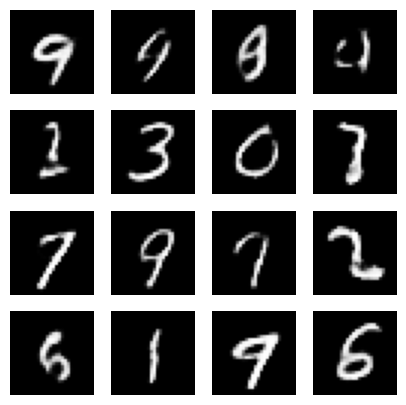

In [34]:
noise_samples = torch.randn(16, 1, 8, 8, device=device)
samples = reflow_module.sample(noise_samples, num_steps=10, image=True).cpu()

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.show()